In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re


import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import utils
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-10-21 18:21:26.908457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 18:21:26.908485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 18:21:26.909542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 18:21:26.915957: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 18:21:28.433591: W tensorflow/comp

# check sampling and labeling progress

In [5]:
# sampled in rna-sample-092324.ipynb and labeled
# last checked 10.18 6p
design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-cdbas-101524-9.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

for name, thing in name2designdata.items():
    print(name, '{:.4f}'.format(np.mean(thing[1])) if thing[1] is not None else None)

cbas-ridge-0.1 0.2948
cbas-ridge-0.2 0.3003
cbas-ridge-0.3 0.3033
cbas-ridge-0.4 0.3075
cbas-ridge-0.5 0.3121
cbas-ridge-0.6 0.3175
cbas-ridge-0.7 0.3290
cbas-ridge-0.8 0.3539
cbas-ridge-0.9 0.4013
dbas-ridge-0.1 0.3294
dbas-ridge-0.2 0.3921
cbas-ff-0.1 0.2885
cbas-ff-0.2 0.2884
cbas-ff-0.3 0.2900
cbas-ff-0.4 0.2898
cbas-ff-0.5 0.2884
cbas-ff-0.6 0.2882
cbas-ff-0.7 0.2907
cbas-ff-0.8 0.2894
cbas-ff-0.9 0.2930
dbas-ff-0.1 0.3009
dbas-ff-0.2 0.3041
dbas-ff-0.3 0.3016
dbas-ff-0.4 0.3019
dbas-ff-0.5 0.3321
dbas-ff-0.6 0.3333
dbas-ff-0.7 0.3257
dbas-ff-0.8 0.3125
dbas-ff-0.9 0.3288
cbas-cnn-0.1 0.2913
cbas-cnn-0.2 0.2912
cbas-cnn-0.3 0.2907
cbas-cnn-0.4 0.2895
cbas-cnn-0.5 0.2917
cbas-cnn-0.6 0.2914
cbas-cnn-0.7 0.2918
cbas-cnn-0.8 0.2910
cbas-cnn-0.9 0.2917
dbas-cnn-0.1 0.3109
dbas-cnn-0.2 0.3065
dbas-cnn-0.3 0.3096
dbas-cnn-0.4 0.3194
dbas-cnn-0.5 0.3138
dbas-cnn-0.6 0.3187
dbas-cnn-0.7 0.3293
dbas-cnn-0.8 0.3347
dbas-cnn-0.9 0.3394
vae-ridge 0.2853


# plot

In [18]:
# load design names to test (copy from rna-selection-092424.ipynb)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    design_names.append(f'cbas-ridge-{q}t19')
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')

In [19]:
# load PP and CP selection results, computed in rna-selection-092424
reload(utils)

pp_target_values = np.arange(0.25, 0.501, 0.003)
n_pp_trial = 200
pp_results_csv_fname = '/data/wongfanc/rna-results/selection-pp-100724.csv'
cp_results_csv_fname = '/data/wongfanc/rna-results/selection-cp-100824.csv'
pp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-pp-cp-100724-truemeans.pkl'

# load CP selection results
cp_df = pd.read_csv(cp_results_csv_fname, index_col=0)
# assert -np.inf LBs in all cases
assert(np.unique(cp_df.to_numpy()) == np.array([-np.inf]))

# load PP selection results and true means
pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
with open(pp_truemeans_pkl_fname, 'rb') as f:
    pp_name2truemeans = pickle.load(f)

# process for plotting
ppworst_v, pperr_v, ppdisc_v, ppval2configs = utils.process_rna_selection_experiments(
    pp_df, pp_target_values, design_names, pp_name2truemeans, n_pp_trial, imp_or_pp='pp', alpha=0.1
)

Processing pp results with the following 96 configurations, 84 target values in [0.25, 0.50], 200 trials, and alpha = 0.1:
  vae-ridge
  cbas-ridge-0.1t19
  cbas-ridge-0.2t19
  cbas-ridge-0.3t19
  cbas-ridge-0.4t19
  cbas-ridge-0.5t19
  cbas-ridge-0.6t19
  cbas-ridge-0.7t19
  cbas-ridge-0.8t19
  cbas-ridge-0.9t19
  dbas-ridge-0.1t19
  dbas-ridge-0.2t19
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0

In [20]:
# load imputation design names to test

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')

In [21]:
# load imputation selection results, computed in rna-selection-092424.ipynb
reload(utils)

imp_target_values = np.arange(0.25, 0.501, 0.003)
n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-102124.csv'
imp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-imputation-102124-truemeans.pkl'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
with open(imp_truemeans_pkl_fname, 'rb') as f:
    imp_name2truemeans = pickle.load(f)
    
impworst_v, imperr_v, impdisc_v, impval2configs = utils.process_rna_selection_experiments(
    imp_df, imp_target_values, design_names, imp_name2truemeans, n_imp_trial, imp_or_pp='imp', alpha=0.1
)

Processing imp results with the following 96 configurations, 84 target values in [0.25, 0.50], 10 trials, and alpha = 0.1:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.5
  adalead-ridge-0.45
  adalead-ridge-0.4
  adalead-ridge-0.35
  adalead-ridge-0.3
  adalead-ridge-0.25
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.5
  adalead-ff-0.45
  adalead-ff-0.4
  adalead-ff-0.35
  adalead-ff-0.3
  adalead-ff-0.25
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  

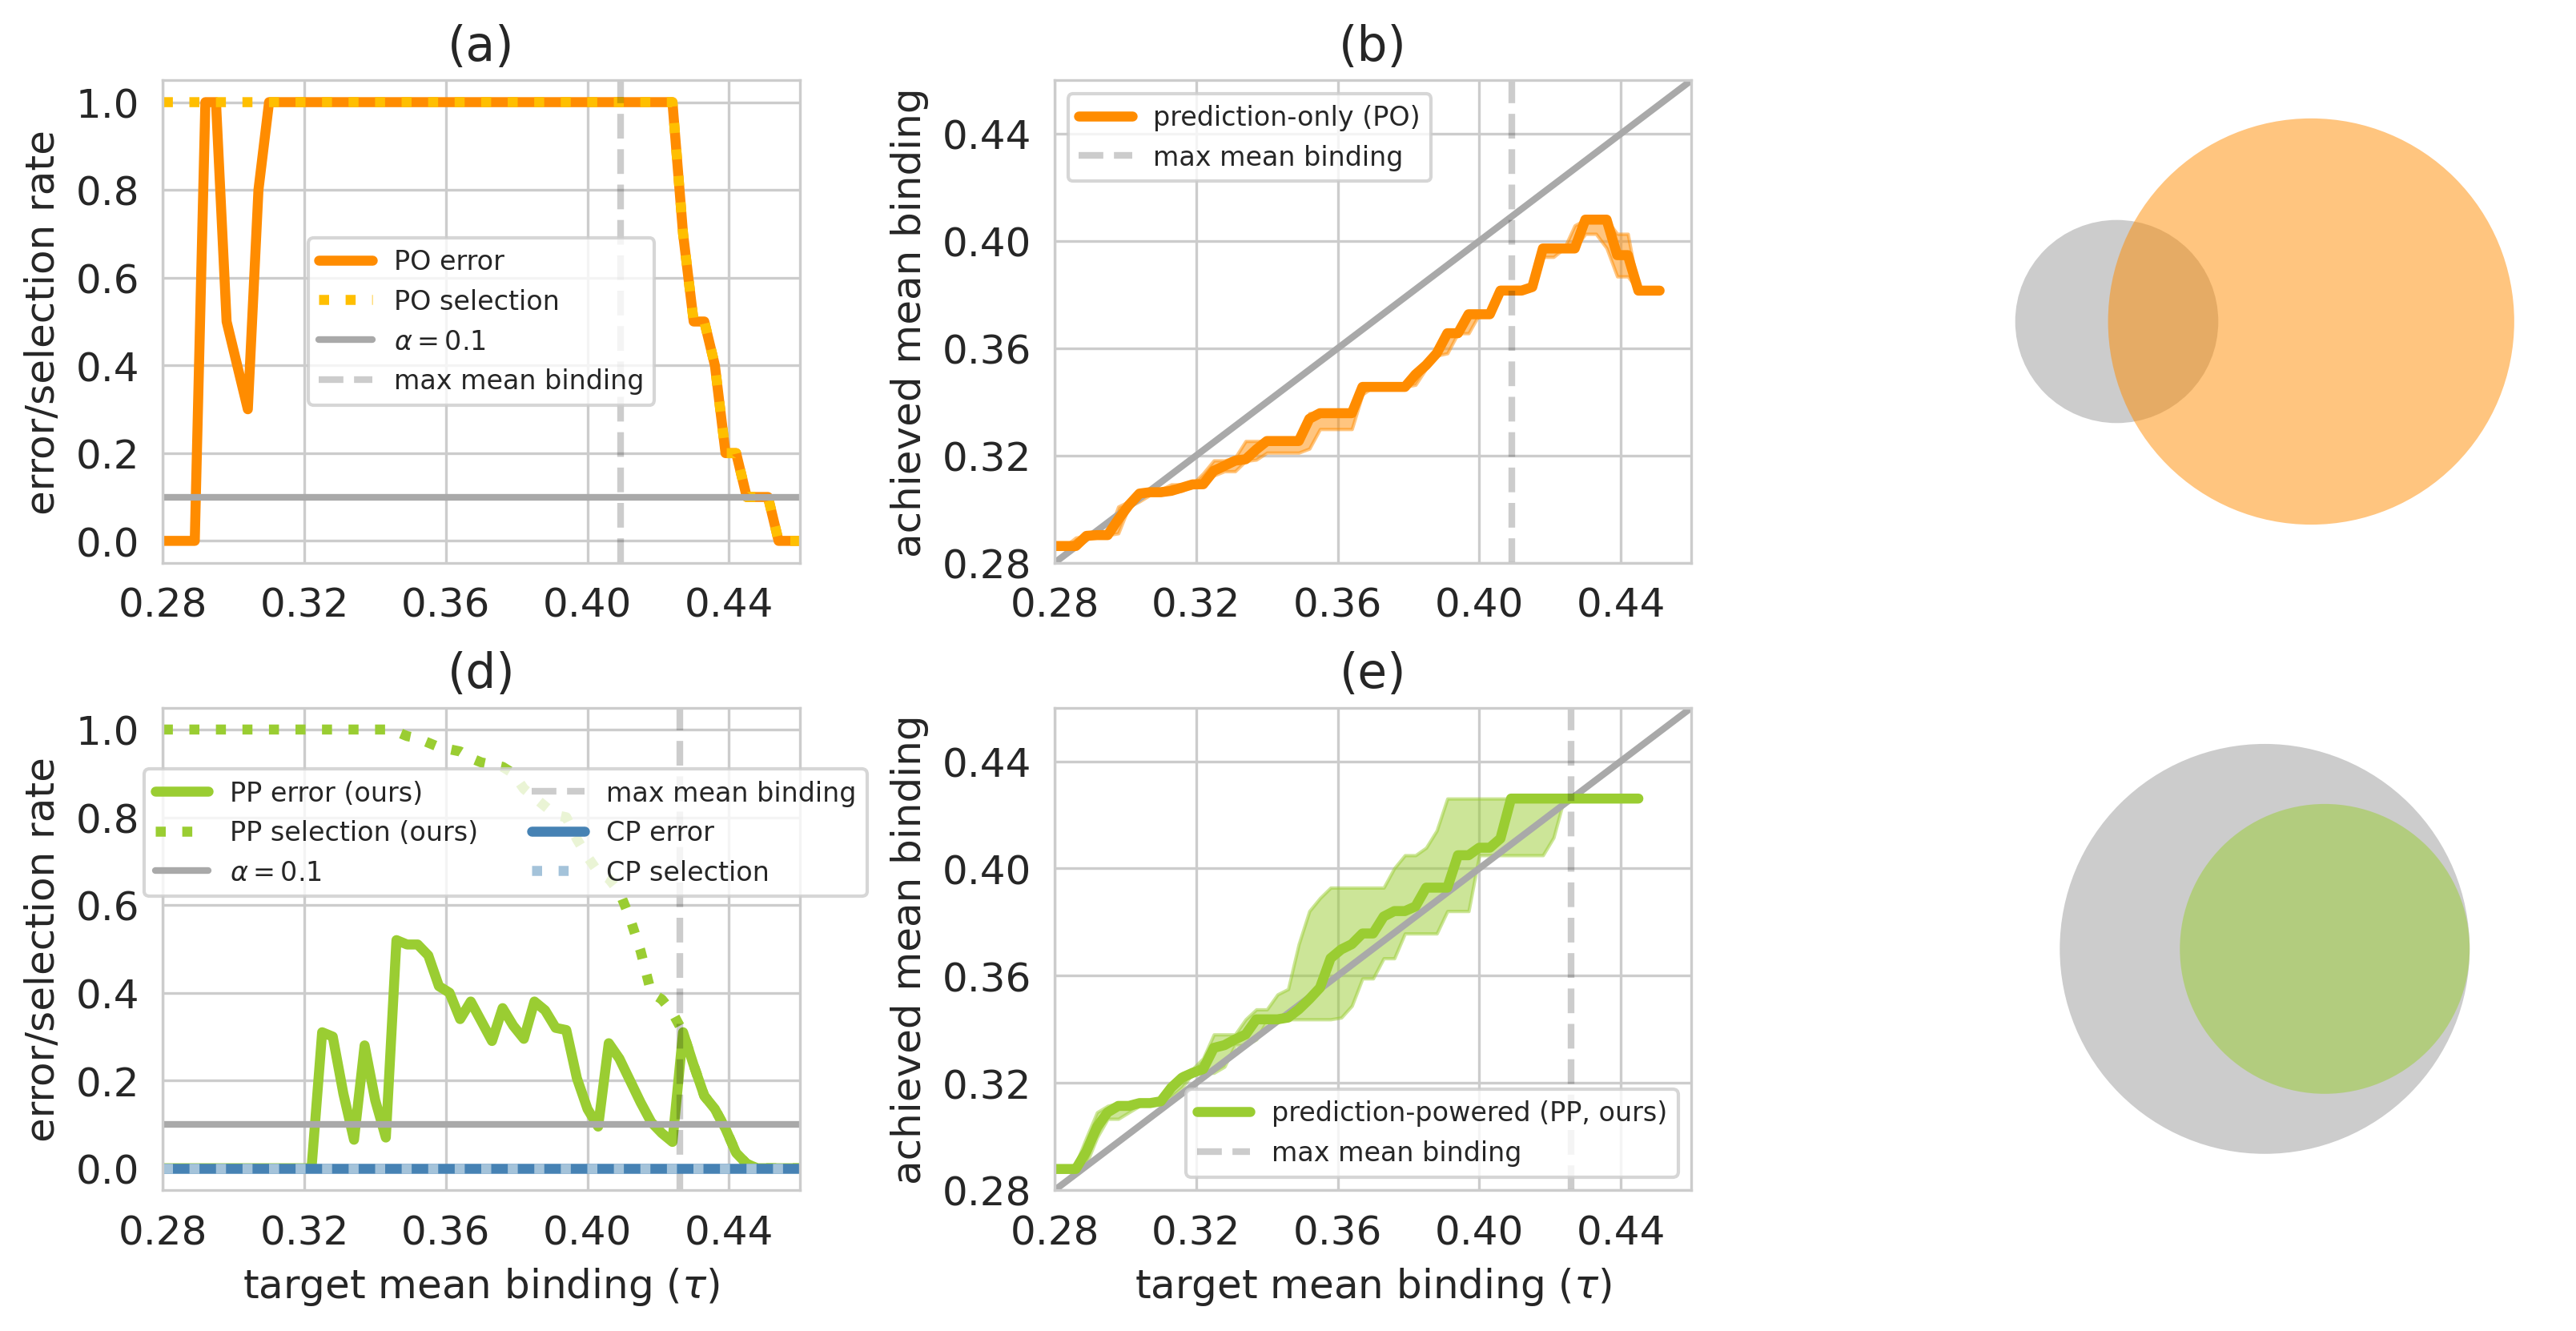

In [42]:
# plot two-row figure
fig, axs = plt.subplots(2, 3, figsize=(13, 6), dpi=300)
ax00 = axs[0, 0]
ax10 = axs[1, 0]
ax01 = axs[0, 1]
ax11 = axs[1, 1]
ax02 = axs[0, 2]
ax12 = axs[1, 2]
fig.subplots_adjust(wspace=0.4, hspace=0.3)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
dark_line_color = 'darkgray'

imp_max_achievable = np.max([np.mean(means_t) for means_t in imp_name2truemeans.values()])
pp_max_achievable = np.max(list(pp_name2truemeans.values()))
imp_xlim = [0.28, 0.46]
imp_xticks = np.arange(0.28, 0.47, 0.04)
pp_xlim = [0.28, 0.46]
pp_xticks = np.arange(0.28, 0.47, 0.04)

# ===== subplots (a, d) =====

ax00.plot(imp_target_values, imperr_v, c=imp_color, linewidth=3, label='PO error');
ax00.plot(imp_target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=3, label='PO selection');
ax00.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax00.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax00.legend(fontsize=8)
ax00.set_ylabel('error/selection rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.05, 0.2))
ax00.set_xlim(imp_xlim)
ax00.set_xticks(imp_xticks)
ax00.set_title('(a)')


ax10.plot(pp_target_values, pperr_v, c=pp_color, linewidth=3, label='PP error (ours)');
ax10.plot(pp_target_values, ppdisc_v, ':', c=pp_color, linewidth=3, label='PP selection (ours)');
ax10.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax10.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax10.axhline(0, color='steelblue', linewidth=3, label='CP error');
ax10.axhline(0, color=(164/255, 195/255, 218/255), linestyle=':', linewidth=3, label='CP selection');
ax10.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(-0.05, 0.9))
ax10.set_ylabel('error/selection rate');
ax10.set_xlabel(r'target mean binding ($\tau$)');
ax10.set_ylim([-0.05, 1.05])
ax10.set_yticks(np.arange(0, 1.05, 0.2))
ax10.set_xticks(pp_xticks)
ax10.set_xlim(pp_xlim)
ax10.set_title('(d)')


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    [np.min(imp_target_values) - 0.02, np.max(imp_target_values) + 0.02],
    c=dark_line_color, alpha=1, linewidth=2
);
ax01.plot(
    imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=3,
)
ax01.fill_between(
    imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)
ax01.set_title('(b)')

ax11.plot([np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
          [np.min(pp_target_values) - 0.02, np.max(pp_target_values) + 0.02],
          c=dark_line_color, alpha=1, linewidth=2)
ax11.plot(
    pp_target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=3,
)
ax11.fill_between(
    pp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax11.legend(fontsize=8)
ax11.set_xlabel(r'target mean binding ($\tau$)');
ax11.set_ylabel('achieved mean binding');
ax11.set_xlim(pp_xlim)
ax11.set_ylim(pp_xlim)
ax11.set_xticks(pp_xticks)
ax11.set_yticks(pp_xticks)
ax11.set_title('(e)')


# ===== subplots (c, f) =====

v = venn2_circles(subsets = (1, 7, 1), ax=ax02);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(imp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

v = venn2_circles(subsets = (1, 0, 1), ax=ax12);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(pp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

# plt.savefig('../figures/gb1-.png')


# find examples for venn diagrams

In [166]:
# construct mapping from target value to imputation configurations that achieve it
imp_val2trueconfigs = {round(val, 4): [] for val in imp_target_values}
for name, means_t in imp_name2truemeans.items():
    for val in imp_target_values:
        val = round(val, 4)
        if np.mean(means_t) >= val:
            if name not in imp_val2trueconfigs[val]:
                imp_val2trueconfigs[val].append(name)
            

In [167]:
# find trials where not all achieving configurations are selected,
# for imputation venn diagram
for val in imp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(imp_val2trueconfigs[val])
        for name in trueconfigs:
            for t in range(2):
                selectedconfigs = set(impval2configs[val][t])
                if name not in selectedconfigs:
                    print(val,
                          len(trueconfigs.difference(selectedconfigs)),
                          len(selectedconfigs.difference(trueconfigs)),
                          len(trueconfigs.intersection(selectedconfigs)))
                    print(trueconfigs.difference(selectedconfigs))
                    print(selectedconfigs.difference(trueconfigs))
                    print(trueconfigs.intersection(selectedconfigs))

0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()
0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()


In [147]:
# construct mapping from target value to PP configurations that achieve it
pp_val2trueconfigs = {round(val, 4): [] for val in pp_target_values}
for name, mean in pp_name2truemeans.items():
    for val in pp_target_values:
        val = round(val, 4)
        if mean >= val:
            assert(name not in pp_val2trueconfigs[val])
            pp_val2trueconfigs[val].append(name)
            

In [165]:
# find trials where not all achieving configurations are selected,
# for PP venn diagram
trial_idx = 13
for val in pp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(val2trueconfigs[val])
        selectedconfigs = set(ppval2configs[val][trial_idx])
        
        for name in trueconfigs:
            if name not in selectedconfigs:  # look for when didn't select some successful ones
                print(val,
                      len(trueconfigs.difference(selectedconfigs)),
                      len(selectedconfigs.difference(trueconfigs)),
                      len(trueconfigs.intersection(selectedconfigs)))
                print(trueconfigs.difference(selectedconfigs))
                print(selectedconfigs.difference(trueconfigs))
                print(trueconfigs.intersection(selectedconfigs))

0.402 1 0 1
{'adalead-cnn-0.01'}
set()
{'cbas-ridge-0.9t19'}
0.406 1 1 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19'}
set()
